# Eulerian outputs (idealized simulation) : Compute the correlation function for a given time window size (T) using the outputs on the model grid

The correlation function is computed using time series at each grid point (4kmx4km grid). The times series are separated in segments of size T and the correlation is computed over each segments and all segments are then combined. We average the results over bins (squares).

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal
import pandas as pd
import crocosi.postp as pp
import phdequinox.croco_drifter as cdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster


In [3]:
client

Client Scheduler: tcp://10.148.0.21:48925 Dashboard: http://10.148.0.21:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load data

In [4]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'#old/'
run = 'jet_cfg1_wp7_m1a1_4km_500a1000j/'
#'old/jet_cfg1_wp75_4km_1500a2000j_itide/'

In [5]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_counter': 'time'})


In [6]:
# Select the number of points (dij) and the temporal resolution (dti)
V = ['u', 'v']
dij = 1
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 36 GB


In [7]:
#Chunks
x,y,t = 'auto', 'auto' , 'auto'
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [8]:
# Functions to interpolate the velocity on the rho grid (instead of the u or v grid)
from collections import OrderedDict

def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [9]:
#Load the mean field
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/ZC_Eulerian_field.nc').persist()
mean_zon = eulerian_field.mean('x_rho')

In [10]:
# Interpolation over the rho grid
for V in ['u','v']:
    ds[V] = x2rho(ds[V],r.xgrid,'extrapolate')
    ds[V] = ds[V]-mean_zon[V+'_mean'] # If mean field substracted : 


In [11]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:       (time: 24000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
  * time          (time) float64 500.0 500.0 500.1 500.1 ... 1e+03 1e+03 1e+03
  * y_rho         (y_rho) float32 -2e+03 2e+03 6e+03 ... 2.878e+06 2.882e+06
  * x_rho         (x_rho) float32 -2e+03 2e+03 6e+03 ... 1.022e+06 1.026e+06
    s_rho_slice0  float32 -0.01
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 4e+03 8e+03 ... 1.016e+06 1.02e+06 1.024e+06
  * y_v           (y_v) float32 0.0 4e+03 8e+03 ... 2.872e+06 2.876e+06 2.88e+06
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    time_instant  (time) float64 dask.array<chunksize=(24000,), meta=np.ndarray>
    f_rho         (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    f             (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
Data variables:
    u             (time, y_rho, x_rho) float32 dask.array<chunksize=(240, 361, 1), meta=np.ndarray>
    v             (time, y_rho, x_rho) float32 dask.array<chunksize=(240, 1, 129), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Oct-06 07:26:22 GMT
    uuid:         9864e038-9586-4208-a4e1-10c84eeb9bf2

In [12]:
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [13]:
# Definition of the functions to compute the correlation
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'valid'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        _kwargs = {'mode': 'valid','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    #vv = vv[...,:]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1[Nr//2:], _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [14]:
# Wrapping function
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        C = xr.apply_ufunc(correlate_E, v1, v2,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [15]:
T = 80 #time window size (size of th segments)
dt = float((ds.time[1]-ds.time[0]).values) # time step
binsize = 50 # binsize over which the correlation will be averaged
_u = ds.v.isel(x_rho=slice(0,2),y_rho=slice(0,2))
lags, _ = wrap_correlate(_u, _u, dt, roll=True, Nr=int(T/dt),detrend=False) #initialization of the lags (used as input)

In [16]:
# Autocorrelation of v
Cvv = wrap_correlate(ds.v, ds.v,dt, lags=lags, roll=True,detrend=False, Nr=int(T/dt))#.persist()
#Cvv_mean = Cvv.mean('x_rho').compute()

<ipython-input-14-82a075f8273b>:9: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(correlate_E, v1, v2,


In [17]:
Cvv = Cvv.persist()

In [18]:
bins_y = np.arange(Cvv.y_rho.min(),Cvv.y_rho.max(),binsize*1e3)
bins_x = np.arange(Cvv.x_rho.min(),Cvv.x_rho.max(),binsize*1e3
                  )
#Cvv.groupby_bins(bins=)

In [19]:
Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[0])&(Cvv.y_rho<=bins_y[1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))

Number of data points : 3354


In [19]:
def resampling(C):
    sample_y = np.random.choice(C.y_rho,size=C.y_rho.size,replace=True)
    sample_x = np.random.choice(C.x_rho,size=C.x_rho.size,replace=True)
    sample = C.sel(y_rho=sample_y,x_rho=sample_x)
    return sample.mean(['y_rho','x_rho'])

In [20]:
from inspect import signature
from scipy import signal
import scipy
def param_fit(x,myfunc,bounds,name,X = 'normalized'):
    """Find the best fit using the function myfunc. The parameters are computed fitting the data using myfunc 
    to the average over all segments for each draws.
    Parameters
    ----------
        x : DataArray
            Correaltionfunction to fit
        myfunc: func
                Function used for the fit
        var : str
              variable to fit
        X : str
            If X='Normalized', the fit will be made on normalized autocorrelation function
        name: str, optional
    
    Returns
    ----------
    out : Dataset
          Dataset containing the parameters fitted using myfunc for all draws.
    """
    sig = signature(myfunc)
    
    if X=='normalized':
        _x = x/x.loc[0] 
    else :
        _x = x
    _x.name = name
 #   pa = np.full((1,len(sig.parameters)-1),np.nan)
    pa,co = scipy.optimize.curve_fit(myfunc,_x.index,_x.values[:,0],bounds=bounds)
    #    err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = pd.DataFrame(pa,index=[V for V in sig.parameters.keys()][1:],columns=[x.name])
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [21]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt,Xt_ns,Xt_s):
    return (Xt_s+Xt_ns*np.exp(-t/Tt))*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Xb,Om):
    return Xb*np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
def Cbar_E(t,Tb,Xb):
    return Xb*np.exp(-t/Tb)#*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xt_ns,Xt_s,Tb,Xb,Omega):
    return Cbar(t,Tb,Xb,Omega)+Ctilde(t,Tt,Xt_ns,Xt_s)
def C_E(t,Tt,Xt_ns,Xt_s,Tb,Xb):
    return Cbar_E(t,Tb,Xb)+Ctilde(t,Tt,Xt_ns,Xt_s)

In [22]:
from inspect import signature
import scipy


# Parameters
myfunc = C #function to use for the fit
bounds = ((1,0,0,0,0,0),(40,np.inf,np.inf,2000,np.inf,1)) # bounds for the fit to avoid non physical results
bounds_E = ((1,0,0,0,0),(40,np.inf,np.inf,2000,np.inf))
ce,cl = 'lightseagreen','firebrick'
sig = signature(myfunc)
Nparams = len([V for V in sig.parameters.keys()][1:]) # Number of parameters to fit

In [23]:
def wrap_bootstrap(df,B,myfunc,bounds,alpha=0.05):
    #y = df_chunked.y_cut
    #resample_bin = df_chunked.drop(columns=['y_cut','id','time','x','y'])
    #_ds = pd.concat([resample_bin.sample(frac=1,replace=True,axis='index').mean('index')
    #                .rename('sample_%s'%(i+1)) for i in range(B)],axis='columns')
    #_ds = pd.concat([resample_bin.mean('index').rename('Original'),_ds],axis='columns')
    #_ds.index = _ds.index.astype('float64')
    #if np.isnan(_ds['Original']).any():
    #    pass
        #print('Failed')
    #else:
    samples = xr.concat([resampling(df) for b in range(B)],dim='sample')
    fitted = pd.concat([param_fit(samples.isel(sample=b).to_dataframe().drop(columns='s_rho_slice0')
                            ,myfunc,bounds,'sample%s'%b,X='') for b in samples.sample.values],axis='columns')

    fitted = pd.concat([param_fit(df.mean(['y_rho','x_rho']).drop('s_rho_slice0').to_dataframe()
                            ,myfunc,bounds,'Original',X=''),fitted],axis='columns')
    deltastar = fitted.sub(fitted['Original'],axis='index')
    q = deltastar.loc[:,'sample0':].quantile([alpha,1-alpha], axis='columns')
    deltau = q.iloc[0]
    deltal = q.iloc[1]
    ci = [fitted['Original'].sub(deltal,axis='index'),fitted['Original'].sub(deltau,axis='index')]
    out = pd.DataFrame(np.array([ci[0].values]),columns=[V+'_lower' for V in fitted.index.values])#,index=y.unique())
    for V in fitted.index.values:
        out[V+'_upper'] = ci[1][V]
        out[V] = fitted['Original'][V]
    return out

In [33]:
B = 10
Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[0])&(Cvv.y_rho<=bins_y[1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))
out = wrap_bootstrap(Cvv_i,B,myfunc,bounds)
for i in range(1,bins_y.size-1):
    Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[i])&(Cvv.y_rho<=bins_y[i+1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
    print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))
    out = pd.concat([out,wrap_bootstrap(Cvv_i,B,myfunc,bounds)])

Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data

In [34]:
out['y']=[b.mid for b in Cvv.groupby_bins('y_rho',bins=bins_y).groups]
out = out.reset_index().set_index('y').drop(columns='index')
ds_out = out.to_xarray()

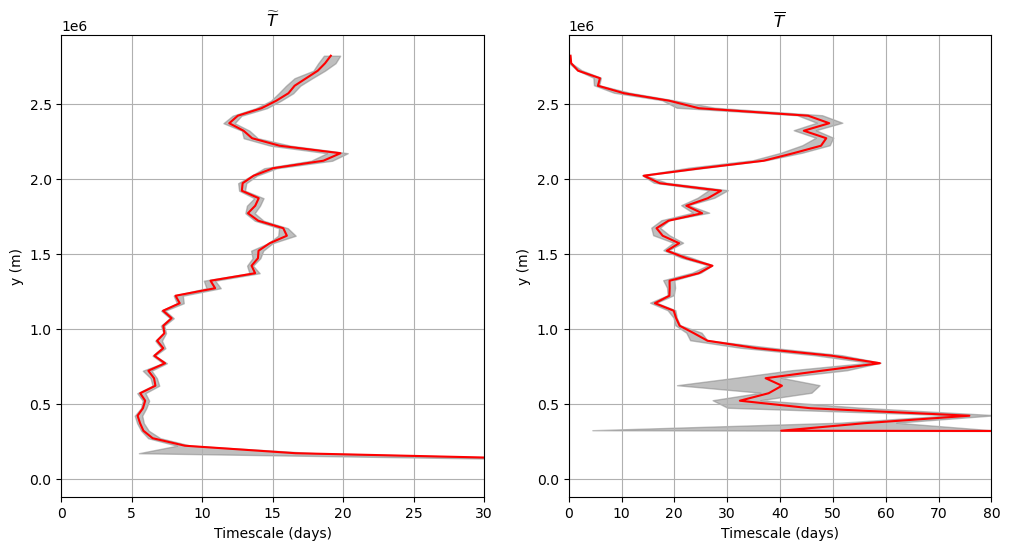

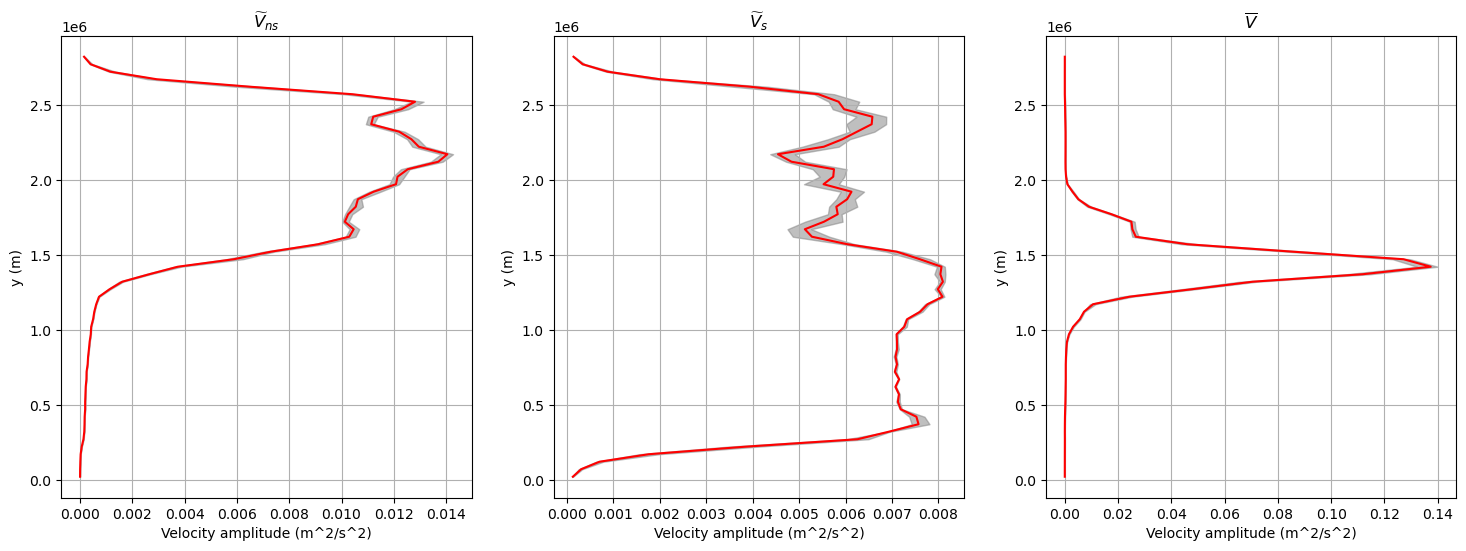

In [35]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for V,ax,title in zip(['Tt','Tb'],axs,[r'$\widetilde{T}$',r'$\overline{T}$']):
    ax.fill_betweenx(ds_out.y,ds_out[V+'_lower'],ds_out[V+'_upper'],color='grey',alpha=0.5)
    ds_out[V].plot(ax=ax,c='r',y='y')
    ax.grid();ax.set_title(title)
    ax.set_xlabel('Timescale (days)'),ax.set_ylabel('y (m)')
axs[1].set_xlim(0,80);axs[0].set_xlim(0,30)
fig,axs = plt.subplots(1,3,figsize=(18,6))
for V,ax,title in zip(['Xt_ns','Xt_s','Xb'],axs,[r'$\widetilde{V}_{ns}$',r'$\widetilde{V}_{s}$',
                                                 r'$\overline{V}$']):
    ax.fill_betweenx(ds_out.y,ds_out[V+'_lower'],ds_out[V+'_upper'],color='grey',alpha=0.5)
    ds_out[V].plot(ax=ax,c='r',y='y')
    ax.grid();ax.set_title(title)
    ax.set_xlabel('Velocity amplitude (m^2/s^2)'),ax.set_ylabel('y (m)')

In [24]:
#Cvv.groupby_bins('y_rho',bins=bins_y).map(wrap_bootstrap,args=(10,myfunc,bounds))

B = 100
Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[0])&(Cvv.y_rho<=bins_y[1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))
out = wrap_bootstrap(Cvv_i,B,myfunc,bounds)
for i in range(1,bins_y.size-1):
    Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[i])&(Cvv.y_rho<=bins_y[i+1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
    print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))
    out = pd.concat([out,wrap_bootstrap(Cvv_i,B,myfunc,bounds)])

Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data

In [ ]:
#Cvv.groupby_bins('y_rho',bins=bins_y).apply(wrap_bootstrap,args=(10,myfunc,bounds))

In [25]:
out['y']=[b.mid for b in Cvv.groupby_bins('y_rho',bins=bins_y).groups]
out = out.reset_index().set_index('y').drop(columns='index')
ds_out = out.to_xarray()

In [26]:
ds_out.attrs.update(**{'Resampling':'100'})

In [27]:
ds_out

<xarray.Dataset>
Dimensions:      (y: 57)
Coordinates:
  * y            (y) float64 2.3e+04 7.3e+04 1.23e+05 ... 2.773e+06 2.823e+06
Data variables: (12/18)
    Tt_lower     (y) float64 40.0 40.0 40.0 11.05 ... 16.65 17.34 18.03 18.34
    Xt_ns_lower  (y) float64 1.961e-06 4.307e-06 ... 0.0003374 0.0001333
    Xt_s_lower   (y) float64 0.0001141 0.0002617 ... 0.0002858 0.0001234
    Tb_lower     (y) float64 2e+03 2e+03 2e+03 2e+03 ... 1.584 -0.4279 -0.2462
    Xb_lower     (y) float64 1.103e-06 1.804e-06 5.444e-06 ... 9.71e-06 5.55e-06
    Omega_lower  (y) float64 -1.834e-07 -0.002408 -7.498e-09 ... 0.5013 0.522
    ...           ...
    Tb_upper     (y) float64 2.001e+03 3.92e+03 2e+03 2e+03 ... 2.061 0.5 0.357
    Tb           (y) float64 2e+03 2e+03 2e+03 2e+03 ... 1.789 0.4778 0.3444
    Xb_upper     (y) float64 2.048e-06 3.892e-06 ... 1.949e-05 1.092e-05
    Xb           (y) float64 1.649e-06 2.949e-06 ... 1.011e-05 5.703e-06
    Omega_upper  (y) float64 1.427e-08 -1.641e-11 1.589e-10 ... 0.6654 0.7475
    Omega        (y) float64 7.193e-09 6.575e-12 7.947e-11 ... 0.5082 0.5273
Attributes:
    Resampling:  100

In [28]:
r.store_diagnostic('ZC_bootstrapE', ds_out, overwrite=True,file_format='netcdf')

data stored in /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp7_m1a1_4km_500a1000j/diagnostics/ZC_bootstrapE.nc


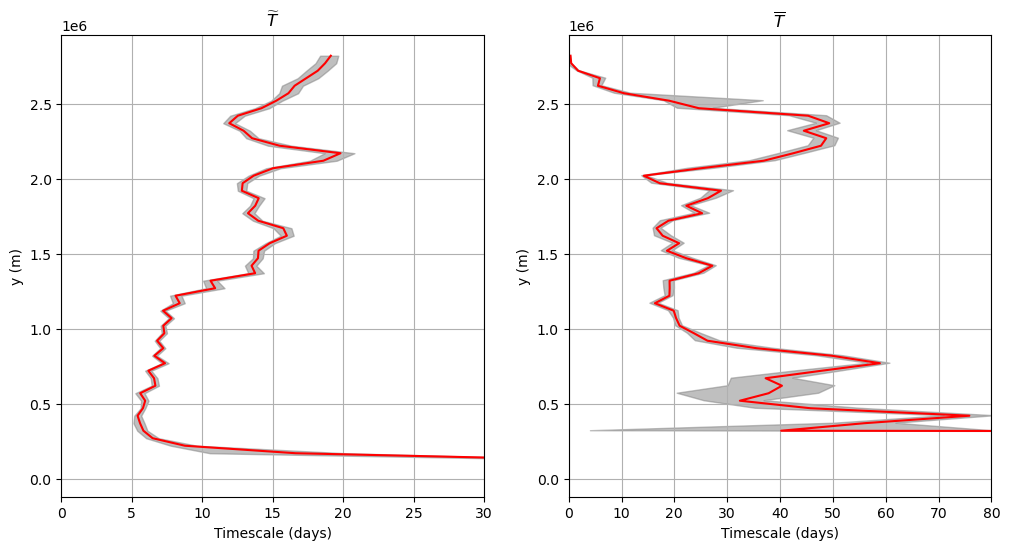

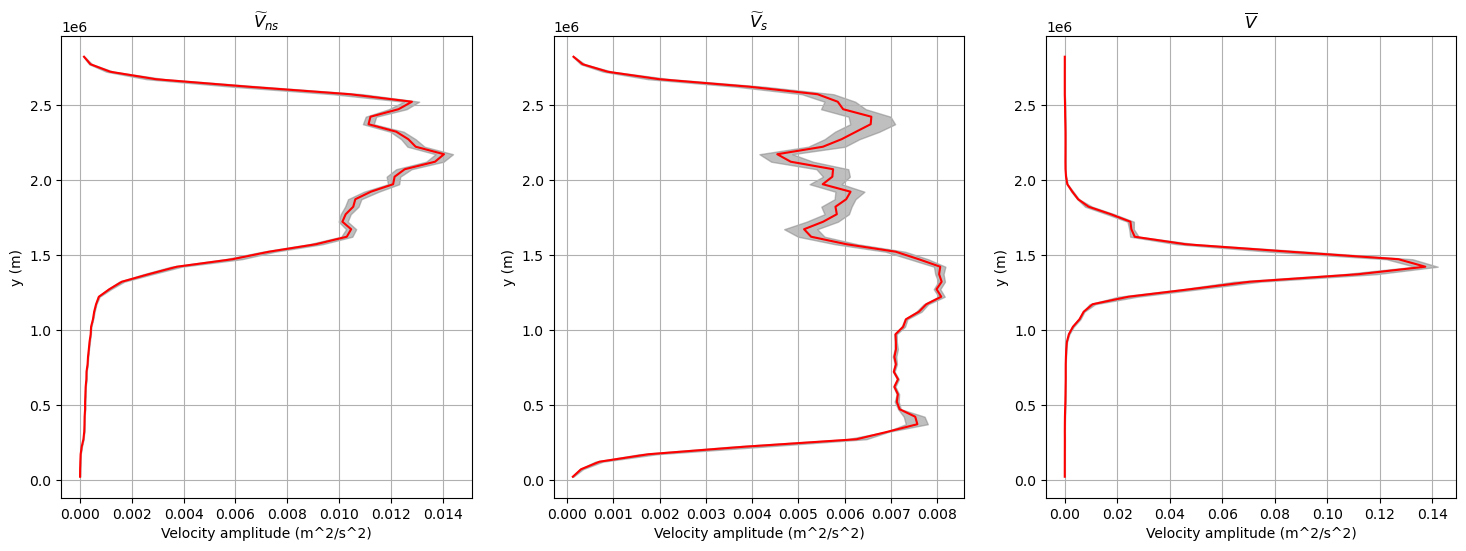

In [32]:

fig,axs = plt.subplots(1,2,figsize=(12,6))
for V,ax,title in zip(['Tt','Tb'],axs,[r'$\widetilde{T}$',r'$\overline{T}$']):
    ax.fill_betweenx(ds_out.y,ds_out[V+'_lower'],ds_out[V+'_upper'],color='grey',alpha=0.5)
    ds_out[V].plot(ax=ax,c='r',y='y')
    ax.grid();ax.set_title(title);
    ax.set_xlabel('Timescale (days)'),ax.set_ylabel('y (m)')
axs[1].set_xlim(0,80);axs[0].set_xlim(0,30)
fig,axs = plt.subplots(1,3,figsize=(18,6))
for V,ax,title in zip(['Xt_ns','Xt_s','Xb'],axs,[r'$\widetilde{V}_{ns}$',r'$\widetilde{V}_{s}$',
                                                 r'$\overline{V}$']):
    ax.fill_betweenx(ds_out.y,ds_out[V+'_lower'],ds_out[V+'_upper'],color='grey',alpha=0.5)
    ds_out[V].plot(ax=ax,c='r',y='y')
    ax.grid();ax.set_title(title)
    ax.set_xlabel('Velocity amplitude (m^2/s^2)'),ax.set_ylabel('y (m)')

In [24]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt,Xt_ns,Xt_s):
    return (Xt_s+Xt_ns*np.exp(-t/Tt))*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Xb):
    return Xb*np.exp(-t/Tb)
def C(t,Tt,Xt_ns,Xt_s,Tb,Xb):
    return Cbar(t,Tb,Xb)+Ctilde(t,Tt,Xt_ns,Xt_s)

In [25]:
from inspect import signature
import scipy


# Parameters
myfunc = C #function to use for the fit
bounds = ((1,0,0,0,0),(40,np.inf,np.inf,2000,np.inf)) # bounds for the fit to avoid non physical results
#bounds_E = ((1,0,0,0,0),(40,np.inf,np.inf,2000,np.inf))
ce,cl = 'lightseagreen','firebrick'
sig = signature(myfunc)
Nparams = len([V for V in sig.parameters.keys()][1:]) # Number of parameters to fit

In [26]:
B = 10
Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[0])&(Cvv.y_rho<=bins_y[1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))
out_omega = wrap_bootstrap(Cvv_i,B,myfunc,bounds)
for i in range(1,bins_y.size-1):
    Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[i])&(Cvv.y_rho<=bins_y[i+1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
    print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))
    out_omega = pd.concat([out_omega,wrap_bootstrap(Cvv_i,B,myfunc,bounds)])

Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data

In [27]:
out_omega['y']=[b.mid for b in Cvv.groupby_bins('y_rho',bins=bins_y).groups]
out_omega = out_omega.reset_index().set_index('y').drop(columns='index')
ds_out_omega = out_omega.to_xarray()

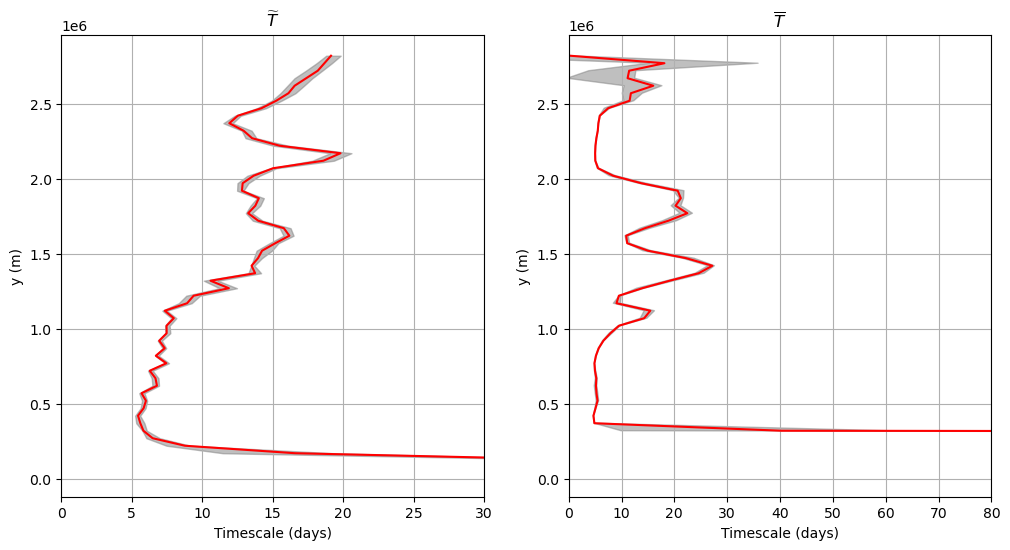

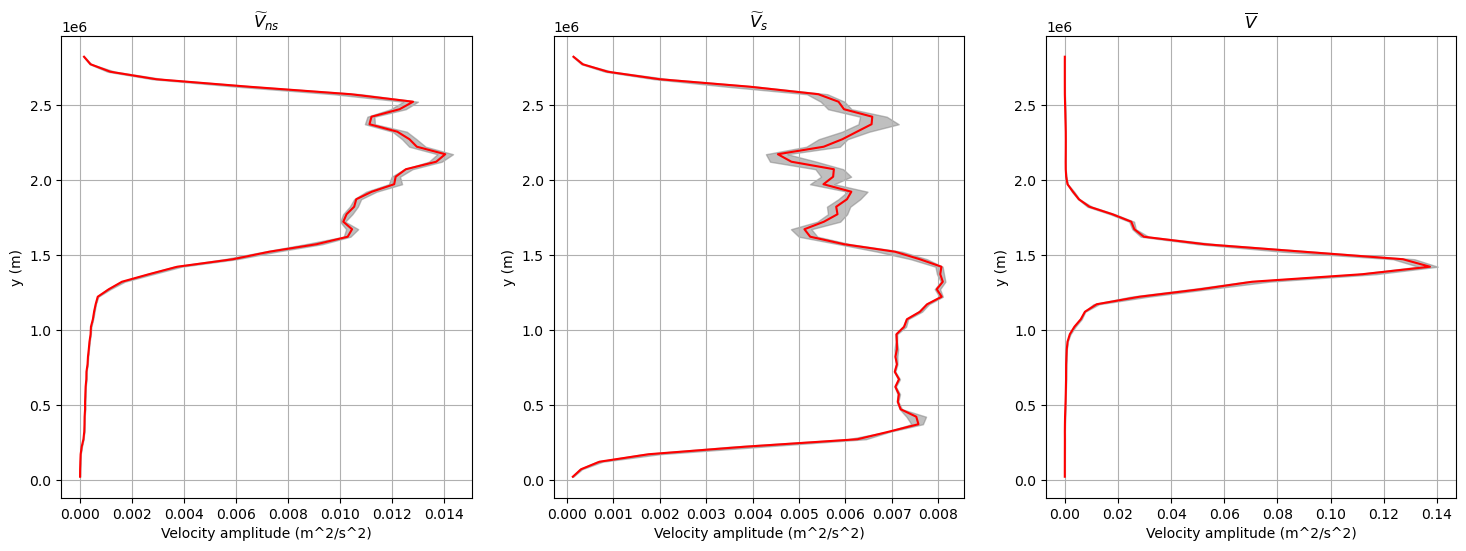

In [28]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for V,ax,title in zip(['Tt','Tb'],axs,[r'$\widetilde{T}$',r'$\overline{T}$']):
    ax.fill_betweenx(ds_out_omega.y,ds_out_omega[V+'_lower'],ds_out_omega[V+'_upper'],color='grey',alpha=0.5)
    ds_out_omega[V].plot(ax=ax,c='r',y='y')
    ax.grid();ax.set_title(title)
    ax.set_xlabel('Timescale (days)'),ax.set_ylabel('y (m)')
axs[1].set_xlim(0,80);axs[0].set_xlim(0,30)

fig,axs = plt.subplots(1,3,figsize=(18,6))
for V,ax,title in zip(['Xt_ns','Xt_s','Xb'],axs,[r'$\widetilde{V}_{ns}$',r'$\widetilde{V}_{s}$',
                                                 r'$\overline{V}$']):
    ax.fill_betweenx(ds_out_omega.y,ds_out_omega[V+'_lower'],ds_out_omega[V+'_upper'],color='grey',alpha=0.5)
    ds_out_omega[V].plot(ax=ax,c='r',y='y')
    ax.grid();ax.set_title(title)
    ax.set_xlabel('Velocity amplitude (m^2/s^2)'),ax.set_ylabel('y (m)')

In [26]:
B = 100
Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[0])&(Cvv.y_rho<=bins_y[1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))
out_omega = wrap_bootstrap(Cvv_i,B,myfunc,bounds)
for i in range(1,bins_y.size-1):
    Cvv_i = Cvv.where((Cvv.y_rho>=bins_y[i])&(Cvv.y_rho<=bins_y[i+1]),drop=True).compute()#.mean(['y_rho','x_rho']).plot()
    print('Number of data points : %s'%int(np.unique(Cvv_i.count(['y_rho','x_rho']))))
    out_omega = pd.concat([out_omega,wrap_bootstrap(Cvv_i,B,myfunc,bounds)])

Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data points : 3354
Number of data

In [28]:
out_omega['y']=[b.mid for b in Cvv.groupby_bins('y_rho',bins=bins_y).groups]
out_omega = out_omega.reset_index().set_index('y').drop(columns='index')
ds_out_omega = out_omega.to_xarray()

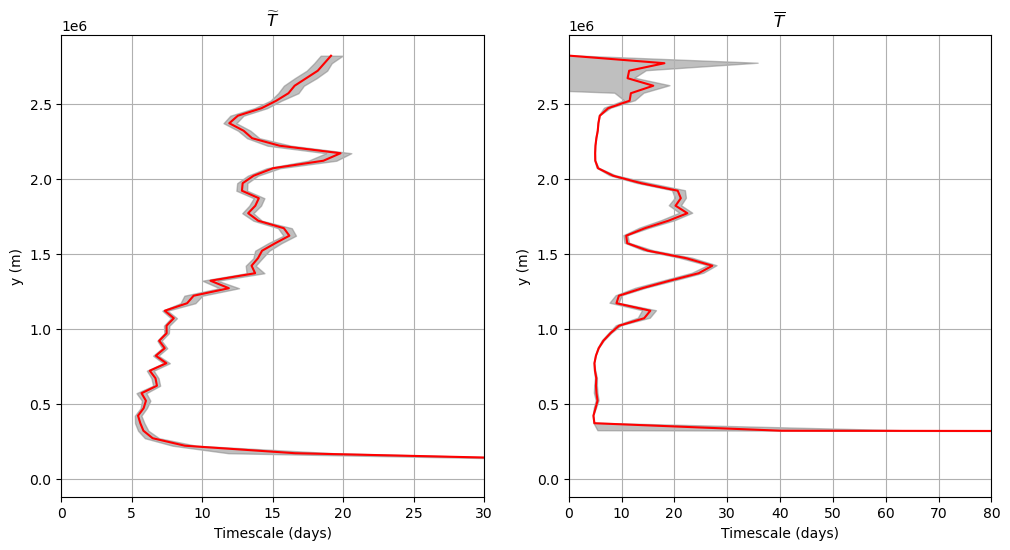

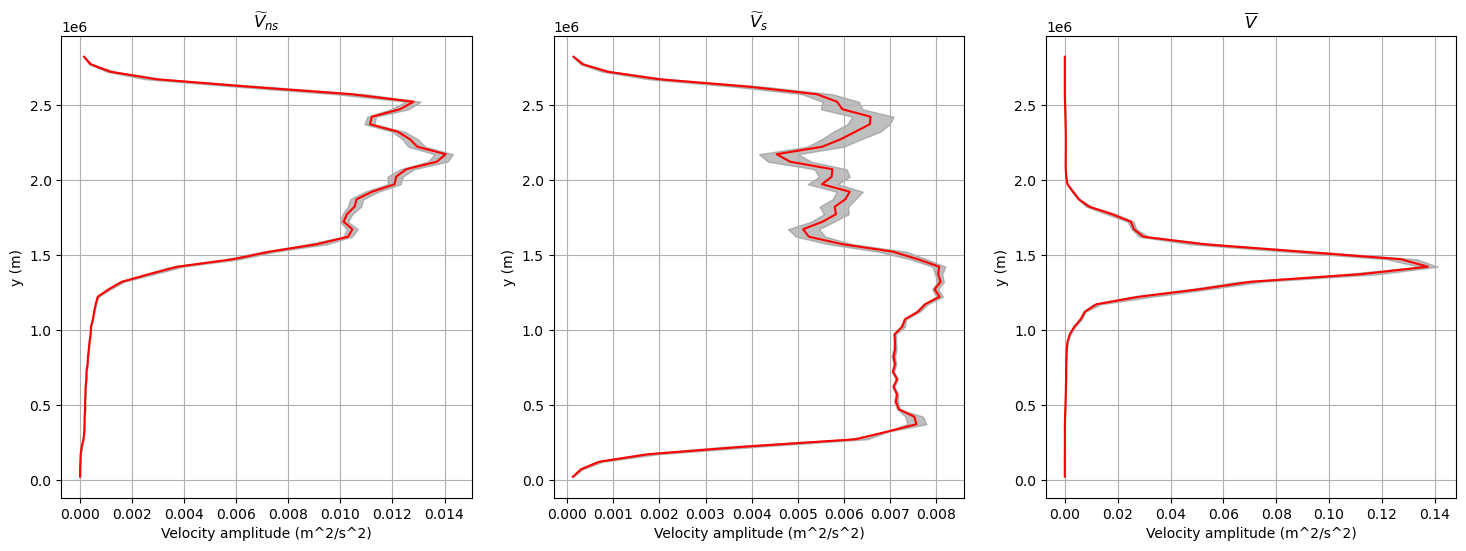

In [30]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for V,ax,title in zip(['Tt','Tb'],axs,[r'$\widetilde{T}$',r'$\overline{T}$']):
    ax.fill_betweenx(ds_out_omega.y,ds_out_omega[V+'_lower'],ds_out_omega[V+'_upper'],color='grey',alpha=0.5)
    ds_out_omega[V].plot(ax=ax,c='r',y='y')
    ax.grid();ax.set_title(title)
    ax.set_xlabel('Timescale (days)'),ax.set_ylabel('y (m)')
axs[1].set_xlim(0,80);axs[0].set_xlim(0,30)

fig,axs = plt.subplots(1,3,figsize=(18,6))
for V,ax,title in zip(['Xt_ns','Xt_s','Xb'],axs,[r'$\widetilde{V}_{ns}$',r'$\widetilde{V}_{s}$',
                                                 r'$\overline{V}$']):
    ax.fill_betweenx(ds_out_omega.y,ds_out_omega[V+'_lower'],ds_out_omega[V+'_upper'],color='grey',alpha=0.5)
    ds_out_omega[V].plot(ax=ax,c='r',y='y')
    ax.grid();ax.set_title(title)
    ax.set_xlabel('Velocity amplitude (m^2/s^2)'),ax.set_ylabel('y (m)')

In [38]:
from inspect import signature
from scipy import signal
import scipy
def fit_v2(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0)),
                     'error' : (['ybin','param'],np.expand_dims(np.sqrt(np.diag(cov)),axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov


In [ ]:
Cvv_i

In [46]:
Cvv.groupby_bins(group = 'y_rho',bins=bins_y).count()

<xarray.DataArray 'correlation' (y_rho_bins: 57679, x_rho: 258, lags: 1921)>
dask.array<where, shape=(57679, 258, 1921), dtype=float64, chunksize=(159, 258, 1921), chunktype=numpy.ndarray>
Coordinates:
  * y_rho_bins    (y_rho_bins) object (-2000.0, -1950.0] ... (2881900.0, 2881...
  * x_rho         (x_rho) float32 -2e+03 2e+03 6e+03 ... 1.022e+06 1.026e+06
    s_rho_slice0  float32 -0.01
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
  * lags          (lags) float64 0.0 0.02083 0.04167 0.0625 ... 39.96 39.98 40.0

In [38]:
def wrap_bootstrap(df_chunked,B,myfunc,bounds,alpha=0.05):
    #y = df_chunked.y_cut
    resample_bin = df_chunked.drop(columns=['y_cut','id','time','x','y'])
    _ds = pd.concat([resample_bin.sample(frac=1,replace=True,axis='index').mean('index')
                    .rename('sample_%s'%(i+1)) for i in range(B)],axis='columns')
    _ds = pd.concat([resample_bin.mean('index').rename('Original'),_ds],axis='columns')
    _ds.index = _ds.index.astype('float64')
    if np.isnan(_ds['Original']).any():
        pass
        #print('Failed')
    else:
        fitted = pd.concat([param_fit(_ds[sample],myfunc,bounds,X='') for sample in _ds.columns],axis='columns')
        deltastar = fitted.sub(fitted['Original'],axis='index')
        q = deltastar.loc[:,'sample_1':].quantile([alpha,1-alpha], axis='columns')
        deltau = q.iloc[0]
        deltal = q.iloc[1]
        ci = [fitted['Original'].sub(deltal,axis='index'),fitted['Original'].sub(deltau,axis='index')]
        out = pd.DataFrame(np.array([ci[0].values]),columns=[V+'_lower' for V in fitted.index.values])#,index=y.unique())
        for V in fitted.index.values:
            out[V+'_upper'] = ci[1][V]
            out[V] = fitted['Original'][V]
        return out

In [39]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt,Xt_ns,Xt_s):
    return (Xt_s+Xt_ns*np.exp(-t/Tt))*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Xb,Om):
    return Xb*np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
def Cbar_E(t,Tb,Xb):
    return Xb*np.exp(-t/Tb)#*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xt_ns,Xt_s,Tb,Xb,Omega):
    return Cbar(t,Tb,Xb,Omega)+Ctilde(t,Tt,Xt_ns,Xt_s)
def C_E(t,Tt,Xt_ns,Xt_s,Tb,Xb):
    return Cbar_E(t,Tb,Xb)+Ctilde(t,Tt,Xt_ns,Xt_s)

In [40]:
from inspect import signature
import scipy


# Parameters
myfunc = C #function to use for the fit
bounds = ((1,0,0,0,0,0),(40,np.inf,np.inf,2000,np.inf,1)) # bounds for the fit to avoid non physical results
bounds_E = ((1,0,0,0,0),(40,np.inf,np.inf,2000,np.inf))
ce,cl = 'lightseagreen','firebrick'
sig = signature(myfunc)
Nparams = len([V for V in sig.parameters.keys()][1:]) # Number of parameters to fit

In [20]:
# Autocorrelation of u
Cuu = wrap_correlate(ds.u, ds.u,dt, lags=lags, roll=True,detrend=False, Nr=int(T/dt))
Cuu_mean = Cuu.mean('x_rho').compute()

In [29]:
cluster.close()